In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

In [2]:
data = pickle.load(open('data/Doherty_example.pickled', 'rb')) # load example data
binsize = 25 # binsize in ms
data_len = 2000 # number of time bins to use for fitting
timepoints = np.arange(0, data_len) #subsample ~40 seconds of data so things will run somewhat quicker
print(data['Y'].shape)
fit_data = {'Y': data['Y'][..., timepoints], 'locs': data['locs'][timepoints, :], 'targets': data['targets'][timepoints, :], 'binsize': binsize}
# fit_data = {'Y': data['Y'], 'locs': data['locs'], 'targets': data['targets'], 'binsize': binsize}
Y = fit_data['Y'] # these are the actual recordings and is the input to our model
targets = fit_data['targets'] # these are the target locations
locs = fit_data['locs'] # these are the hand positions

Y = Y[:, np.mean(Y,axis = (0, 2))/0.025 > 8, :] #subsample highly active neurons so things will run a bit quicker
# Y_test = Y[..., 1000:] # hold out some data for testing
# Y = Y[..., :1000] # use first 1000 time bins for training
print(Y.shape)
ntrials, n, T = Y.shape # Y should have shape: [number of trials (here 1) x neurons x time points]

ts = np.arange(Y.shape[-1])*fit_data['binsize'] # measured in ms
cs = CubicSpline(ts, locs) # fit cubic spline to behavior
vels = cs(ts, 1) # velocity (first derivative)


(1, 200, 70482)
(1, 94, 2000)


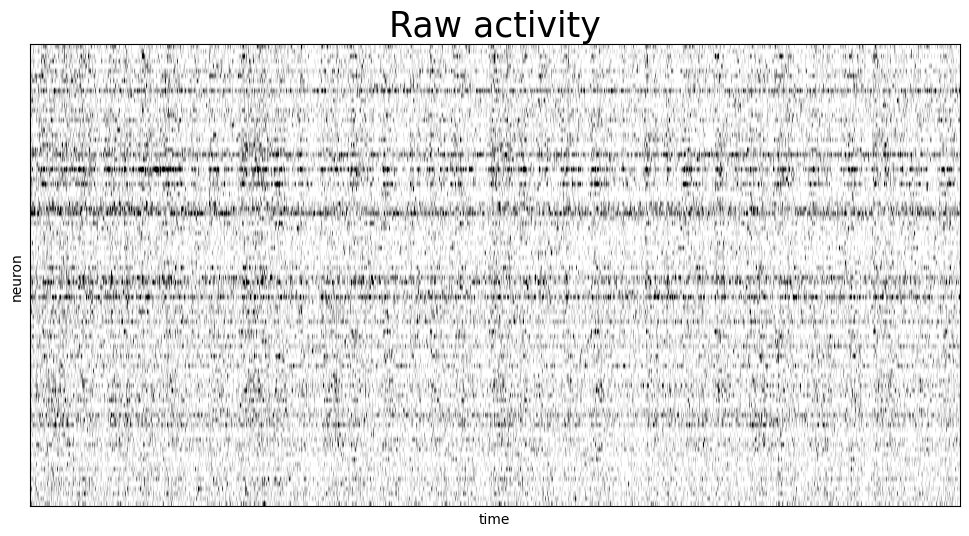

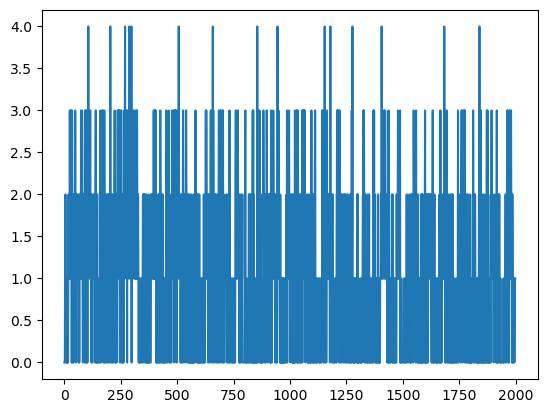

In [3]:
plt.figure(figsize = (12, 6))
plt.imshow(Y[0, ...], cmap = 'Greys', aspect = 'auto', vmin = np.quantile(Y, 0.01), vmax = np.quantile(Y, 0.99))
plt.xlabel('time')
plt.ylabel('neuron')
plt.title('Raw activity', fontsize = 25)
plt.xticks([])
plt.yticks([])
plt.show()

# Plot spikes for neuron with highest firing rate
# plt.figure(figsize = (12, 6))
plt.plot(Y[0, np.argmax(np.mean(Y, axis = -1)), :])
plt.show()

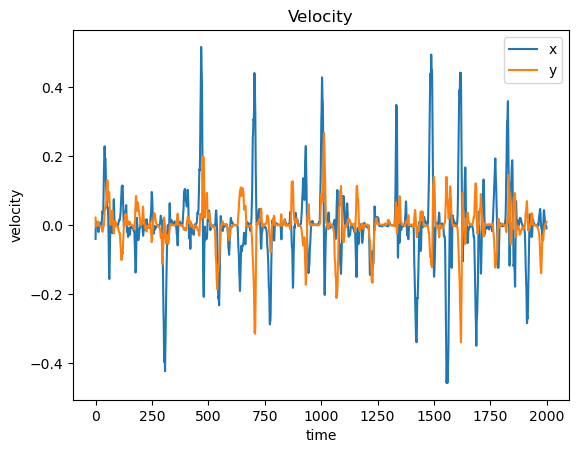

(1, 94, 2000) (2000, 2)


In [4]:
plt.plot(vels[:, 0], label = 'x')
plt.plot(vels[:, 1], label = 'y')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.title('Velocity', fontsize = 12)
plt.show()

print(Y.shape, vels.shape)

torch.Size([1, 10, 1000])


tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
step 0 LL -0.4187312950721154
step 1 LL -0.43955213341346155
step 2 LL -0.44090703876201925
step 3 LL -0.4329616887019231
step 4 LL -0.4255167518028846
step 5 LL -0.4150914212740385
step 6 LL -0.41102392578125
step 7 LL -0.40814254056490384
step 8 LL -0.39880322265625
step 9 LL -0.39252865835336537
step 10 LL -0.3914772761418269
step 11 LL -0.38807023737980767
step 12 LL -0.38217916165865384
step 13 LL -0.3823968599759615
step 14 LL -0.3804752478966346
step 15 LL -0.3794775766225962
step 16 LL -0.3768166691706731
step 17 LL -0.37333251953125
step 18 LL -0.3705026667668269
step 19 LL -0.36911977914663463
step 20 LL -0.3692045147235577
step 21 LL -0.3675681715745192
step 22 LL -0.36518990384615385
step 23 LL -0.3643272986778846
step 24 LL -0.36195545372596155
step 25 LL -0.36051600060096156
step 26 LL -0.36051273287259616
step 27 LL -0.35965801532451924
step 28 LL -0.3565249774639423
step 29 LL -0.3552930438701923
step 30 LL -0.

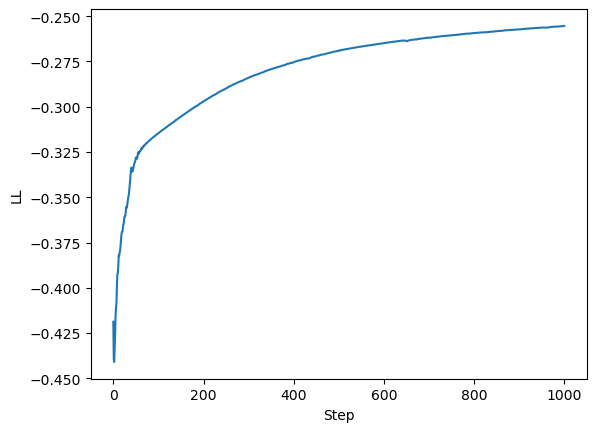

In [5]:
link_fn = torch.nn.functional.softplus
lik = Poisson_noise()

# link_fn = lambda x: x
# lik = Negative_binomial_noise(Y=Tensor(Y))

np.random.seed(0)
torch.manual_seed(0)

# v = vels.T[None, ...]
# print(v.shape)
# model = LDS(Tensor(v), Tensor(Y), lik, link_fn=link_fn)
# train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 5e-3}
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

suffix = '10'

# Fixed generative model
z = Tensor(np.load('z_hat' + suffix + '.npy'))
print(z.shape)
A = Tensor(np.load('params/A' + suffix + '.npy'))[None, ...].to(device)
B = Tensor(np.load('params/B' + suffix + '.npy'))[None, ...].to(device)
W = np.load('params/W' + suffix + '.npy')
mu0 = Tensor(np.load('params/mu0' + suffix + '.npy'))[None, ...].to(device)
Sigma0_half = Tensor(np.load('params/Sigma0_half' + suffix + '.npy'))[None, ...].to(device)

def is_lower_triangular(tensor):
    return torch.all(tensor.triu(1) == 0)
print(is_lower_triangular(Tensor(Sigma0_half)))
print(is_lower_triangular(Tensor(B)))

# print(B - torch.linalg.cholesky(B @ B.transpose(-1,-2)))

train_len = 1000
Y_train = Y[..., :train_len]
model = LDS(z, Tensor(Y_train), lik, link_fn=link_fn, A=A, B=B, mu0=mu0, Sigma0_half=Sigma0_half, trained_z=False, fixed_d=False)
train_params = {'batch_size': None, 'n_mc': 200, 'lrate': 1e-3, 'max_steps': 1001, 'step_size': 500}
model.train_supervised_model(model.training_params(**train_params))
model.plot_LL()

In [6]:
# for name, prm in model.named_parameters():
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')
print('sigma_x', model.sigma_x)
print('d', model.d)
print((model.C @ model.W).sum(axis=-1))


# print(model.lik.total_count)

sigma_x tensor(0.0636, device='cuda:0', grad_fn=<ExpBackward0>)
d Parameter containing:
tensor(-0.5927, device='cuda:0', requires_grad=True)
tensor([[-3.4227,  3.9055,  3.6730,  2.4655, -4.3009,  0.8499,  4.7627,  0.5006,
         -1.6806, -0.6782,  3.5176,  4.8383,  3.5357, -0.9494,  3.6587,  1.5677,
         -2.7454,  0.4042,  3.7337,  2.8583,  2.9281,  0.3844,  1.6193,  0.1353,
         -2.7961,  3.1488,  2.1881, -0.2729, -0.5310,  8.2985,  1.9765,  4.1003,
          4.2885,  0.0691, -1.4456, -3.3092,  5.6284,  1.5455,  0.8358,  1.8715,
         -0.0521, -0.4028,  2.7264,  1.0941, -1.9613, -5.0795, -0.2609,  0.7231,
          0.4147,  2.6673,  0.9301, -6.0929,  4.0549,  0.7250,  5.7883, -0.7375,
          1.3480, -1.4857,  5.4908,  1.9252, -1.7566, -1.2743,  1.3366,  5.5249,
          1.4205, -2.3646, -0.1067,  0.3164,  0.5108, -1.7868, -3.2163,  2.5759,
          2.9794,  2.2570,  2.5809, -3.3679,  0.9899, -0.0670,  2.1957,  2.9819,
         -2.2941,  1.1239,  5.3536, -0.9196,  3.6

step 0 LL -0.6899478266289893
step 1 LL -0.6838789685837766
step 2 LL -0.680232775099734
step 3 LL -0.6775006025598405
step 4 LL -0.6755137757646277
step 5 LL -0.6739838555518617
step 6 LL -0.6722365359042554
step 7 LL -0.6710137757646276
step 8 LL -0.6700374625997341
step 9 LL -0.6693306183510638
step 10 LL -0.6687121218417553
step 11 LL -0.6682721077127659
step 12 LL -0.6679715342420213
step 13 LL -0.6675682347074469
step 14 LL -0.6672075714760638
step 15 LL -0.6669422165890957
step 16 LL -0.6668136220079787
step 17 LL -0.6666879155585106
step 18 LL -0.6665362367021277
step 19 LL -0.6663067237367021
step 20 LL -0.6661282621343085
step 21 LL -0.6658668342752659
step 22 LL -0.6658041264960106
step 23 LL -0.6655705826130319
step 24 LL -0.665475939162234
step 25 LL -0.6653781374667553
step 26 LL -0.6653344622672872
step 27 LL -0.6651942528257979
step 28 LL -0.6651176238364361
step 29 LL -0.6651009599401596
step 30 LL -0.66497265625
step 31 LL -0.664826130319149
step 32 LL -0.664732629654

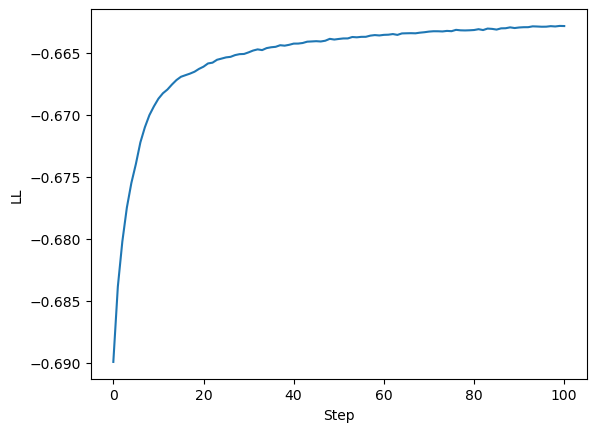

In [7]:
model.freeze_params()
rec_model = RecognitionModel(model, rnn=True)
train_params = {'batch_size': None, 'step_size': 100, 'lrate': 1e-3, 'max_steps': 101, 'n_mc_x': 50, 'n_mc_z': 100, 'batch_mc_z': 50}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

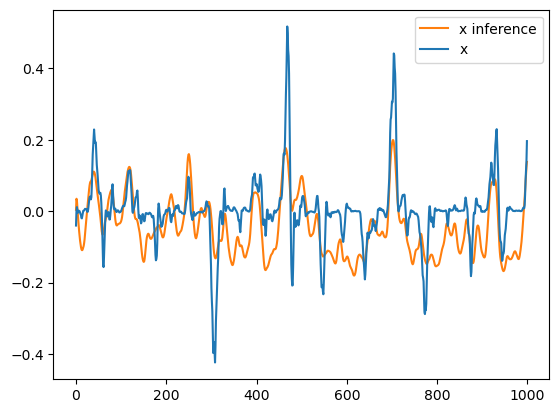

0.003474562175634577
0.3871857370127184


In [9]:

z = rec_model.test_z(rec_model.gen_model.Y)

# Y_test = Y[..., train_len:]
# z = rec_model.test_z(Tensor(Y_test).to(device))

z = z.detach().cpu().numpy()
z = W @ z

# _vels = vels[train_len:]
_vels = vels[:train_len]

plt.plot(z[0,0,:], label = 'x inference', color = 'C1')
# plt.plot(z[0,1,:], label = 'y inference', color = 'C1')
plt.plot(_vels[:, 0], label = 'x', color = 'C0')
# plt.plot(_vels[:, 1], label = 'y', color = 'C0')
plt.legend()
plt.show()

# print R^2 for x and y decoding using sklearn
print(r2_score(_vels[:, 0], z[0,0,:]))
print(r2_score(_vels[:, 1], z[0,1,:]))